# Interest rates in Brazil - The DI curve

In [ ]:
### Marcos Costa Santos Carreira - Jun 2017

## Packages management

In [51]:
%matplotlib inline

In [242]:
import fileinput
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dtt
from dateutil.parser import parse
import itertools
#import xlwings

from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from pandas.tseries.offsets import *

import requests
import bs4

## 1. Define Holidays

http://en.wikipedia.org/wiki/Computus

In [53]:
def IanTaylorEasterJscr(year):
    a = year % 19
    b = year >> 2
    c = b // 25 + 1
    d = (c * 3) >> 2
    e = ((a * 19) - ((c * 8 + 5) // 25) + d + 15) % 30
    e += (29578 - a - e * 32) >> 10
    e -= ((year % 7) + b - d + e + 2) % 7
    d = e >> 5
    day = e - d * 31
    month = d + 3
    return year, month, day
def ITEJ(year):
    a = year % 19
    b = year >> 2
    c = b // 25 + 1
    d = (c * 3) >> 2
    e = ((a * 19) - ((c * 8 + 5) // 25) + d + 15) % 30
    e += (29578 - a - e * 32) >> 10
    e -= ((year % 7) + b - d + e + 2) % 7
    d = e >> 5
    day = e - d * 31
    month = d + 3
    return pd.datetime(year, month, day)

In [54]:
#[IanTaylorEasterJscr(2014), ITEJ(2014)]

In [55]:
def ReligiousHolidays(year):
    easter = ITEJ(year)
    shrvmon = easter - 48*pd.tseries.offsets.DateOffset()
    shrvtue = easter - 47*pd.tseries.offsets.DateOffset()    
    goodfri = easter - 2*pd.tseries.offsets.DateOffset()
    corpchr = easter + 60*pd.tseries.offsets.DateOffset()
    return [shrvmon, shrvtue, goodfri, corpchr]

In [56]:
#ReligiousHolidays(2014)

In [57]:
def lastbdy(year):
    offset = pd.tseries.offsets.BYearEnd()
    return offset.rollforward(pd.datetime(year, 1, 1))

In [58]:
#lastbdy(2014)

In [59]:
def getFixedHolidaysBR(startyear, endyear):
    listmd = [[1, 1], [4, 21], [5, 1], [9, 7], [10, 12], [11, 2], [11, 15], [12, 25]]
    ans = []
    for y in range(startyear, endyear+1):
        for d in listmd:
            ans = ans + [pd.datetime(y, d[0], d[1])]
    return ans

In [60]:
#getFixedHolidaysBR(2014, 2014)

In [61]:
def getFixedHolidaysBVMF(startyear, endyear):
    listmd = [[1, 25], [7, 9], [11, 20], [12, 24]]
    ans = []
    for y in range(startyear, endyear+1):
        for d in listmd:
            if not( d == [11, 20] and y <2004 ):
                ans = ans + [pd.datetime(y, d[0], d[1])]
    return ans

In [62]:
#getFixedHolidaysBVMF(2014, 2014)

In [63]:
def FloHolBRd(startingyear, endyear):
    ans = []
    for y in range(startingyear, endyear+1):
        ans = ans + ReligiousHolidays(y)
    return ans

In [64]:
def FloHolBVMFd(startingyear, endyear):
    ans = []
    for y in range(startingyear, endyear+1):
        ans = ans + [lastbdy(y)]
    return ans

In [65]:
HolBRFix = getFixedHolidaysBR(1999, 2049)
HolBRFlo = FloHolBRd(1999, 2049)
HolBR = HolBRFix+HolBRFlo
bdayBR = CustomBusinessDay(holidays=HolBR)

In [203]:
HolBVMFFix = getFixedHolidaysBVMF(1999, 2049)
HolBVMFlo = FloHolBVMFd(1999, 2049)
HolBVMF = HolBRFix+HolBRFlo+HolBVMFFix+HolBVMFlo
bdayBVMF = CustomBusinessDay(holidays=HolBVMF)

## 2. Define BD(date1, date2, Holidays)

In [ ]:
begcal=pd.Timestamp(pd.datetime(1999,1,1))
endcal=pd.Timestamp(pd.datetime(2049,12,31))

In [67]:
bdBRrange = pd.date_range(begcal,endcal, freq=bdayBR)
bdBRi = pd.Series(np.arange(len(bdBRrange)), index = bdBRrange)

In [68]:
bdBVMFrange = pd.date_range(begcal,endcal, freq=bdayBVMF)
bdBVMFi = pd.Series(np.arange(len(bdBVMFrange)), index = bdBVMFrange)

In [108]:
def bdbt(date1, date2, cal):
    return cal[date2] - cal[date1]

def bdBR(date1, date2):
    return bdbt(date1, date2, bdBRi)
        
def bdBM(date1, date2):
    return bdbt(date1, date2, bdBVMFi)

In [70]:
#bdbt(pd.datetime(2014, 9, 12), pd.datetime(2029, 1, 2), bdBRi)

In [71]:
#pd.datetime(2014, 9, 12) + 3590 * bdayBR

In [72]:
#bdbt(pd.datetime(2014, 9, 12), pd.datetime(2029, 1, 2), bdBVMFi)

In [73]:
#pd.datetime(2014, 9, 12) + 3535 * bdayBVMF

## 3. Define COPOM Dates, COPOMBDs and Last COPOM Move (LCM)

### 3.1 Past dates and meetings

In [74]:
page = requests.get('http://www.bcb.gov.br/?INTEREST')
soup = bs4.BeautifulSoup(page.text, "lxml")
tabela = soup.find('table')

In [75]:
def mstrip(s):
    if (s == None or s.strip() == u''):
        return np.nan
    else:
        return s.strip()

In [76]:
def rton(row):
    return [int(row[0]), pd.to_datetime(row[1]), row[2], row[3],
            float(row[4]), float(row[5]), float(row[6]), float(row[7])]

In [77]:
COPOMt = []
#tabela.findAll("th") - This was useful but i forgot why
#The first 3 rows are the header - let's get the data only
#We will add the header later
for row in tabela.findAll("tr")[3:]:
    cells = row.findAll("td")
    arow = row.findAll("td")[0].a.contents
    if arow==[]:
        arow=np.nan
    else:
        arow=arow[0]
    trow = [mstrip(cell.find(text=True)) for cell in cells]
    trow.insert(1, arow)
    trow[2] = pd.to_datetime(trow[2])
    dtl = trow[4].partition(" - ")
    trow[4] = pd.to_datetime(dtl[0])
    trow.insert(5, pd.to_datetime(dtl[2]))
    trow[6] = float(trow[6])
    trow[7] = float(trow[7])
    trow[8] = float(trow[8])
    trow[9] = float(trow[9])
    COPOMt = COPOMt + [trow]

In [78]:
coldfC = ['Meeting', 'Ex', 'Date', 'Bias', 'Start', 'End',
          'SETA', 'TBAN', 'SELICef', 'SELICpy']
dfCOPOM = pd.DataFrame(COPOMt, columns=coldfC)

In [79]:
coldfC2=['Meeting','Ex','Date','Bias','Start','End','SETA']
cut=dfCOPOM[dfCOPOM['Date']=='1999-03-04'].index[0]
dfCOPOM2=(dfCOPOM.loc[:cut])[coldfC2]
dfCOPOM2['Meeting'] = dfCOPOM2['Meeting'].fillna(method='pad')
dfCOPOM2['Date'] = dfCOPOM2['Date'].fillna(dfCOPOM2['Start'])
dfCOPOM2.sort_values('Date',inplace=True)
dfCOPOM2.set_index('Date',inplace=True)

In [80]:
dfCOPOM2['SETAchg'] = 100*dfCOPOM2['SETA'].diff()

In [81]:
dfCOPOM2.tail()

,Meeting,Ex,Bias,Start,End,SETA,SETAchg
Date,,,,,,,
2016-11-30,203,NaN,NaN,2016-12-01,2017-01-11,13.75,-25.0
2017-01-11,204,NaN,NaN,2017-01-12,2017-02-22,13.00,-75.0
2017-02-22,205,NaN,NaN,2017-02-23,2017-04-12,12.25,-75.0
2017-04-12,206,NaN,NaN,2017-04-13,2017-05-31,11.25,-100.0
2017-05-31,207,NaN,NaN,2017-06-01,NaT,10.25,-100.0


In [82]:
#dfCOPOM['SETAchg'] = 100*(dfCOPOM['SETA'][:-32] - dfCOPOM['SETA'][:-32].shift(-1))
#dfCOPOM['SETAchg2'] = (dfCOPOM['SETAchg'] - dfCOPOM['SETAchg'].shift(-1))
#dfCOPOM['SETAchgS'] = np.sign(dfCOPOM['SETAchg'])
#dfCOPOM['SETAchgS2'] = (dfCOPOM['SETAchgS'] - dfCOPOM['SETAchgS'].shift(-1))

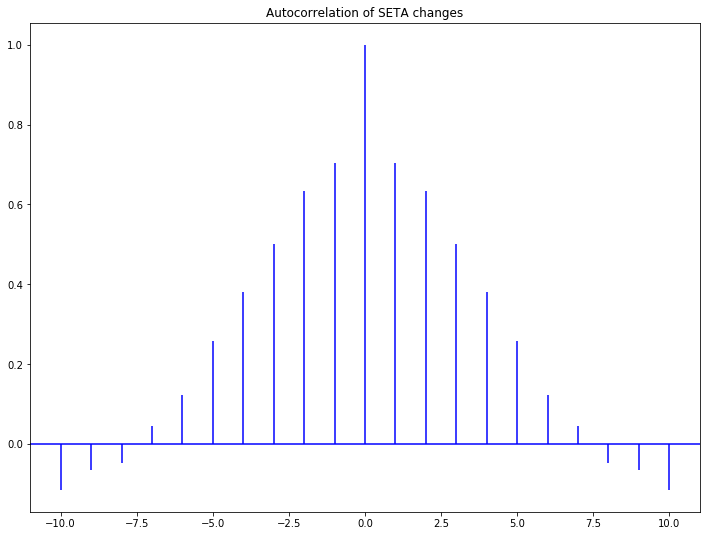

In [83]:
plt.figure(figsize=(12,9));
plt.title('Autocorrelation of SETA changes');
plt.acorr(dfCOPOM2['SETAchg'].dropna(),color='blue');

In [96]:
def LCM(date, base):
    return base[base.index<date]['SETAchg'][-1]

def LCM3(date, base):
    return base[base.index<date]['SETAchg'][-3:]

In [97]:
[LCM('2011-08-31', dfCOPOM2), LCM('2011-09-01', dfCOPOM2)]

[25.0, -50.0]

In [98]:
[LCM3('2011-08-31', dfCOPOM2), LCM3('2011-09-01', dfCOPOM2)]

[Date
 2011-04-20    25.0
 2011-06-08    25.0
 2011-07-20    25.0
 Name: SETAchg, dtype: float64, Date
 2011-06-08    25.0
 2011-07-20    25.0
 2011-08-31   -50.0
 Name: SETAchg, dtype: float64]

### 3.2 Future meetings

In [45]:
COPOM2017 = [pd.datetime(2017, 1, 11), pd.datetime(2017, 2, 22), pd.datetime(2017, 4, 12), pd.datetime(2017, 5, 31),
             pd.datetime(2017, 7, 26), pd.datetime(2017, 9, 6), pd.datetime(2017, 10, 25), pd.datetime(2017, 12, 6)]

### 3.3 All meetings for a given date

In [46]:
allCOPOMs = dfCOPOM2.index | COPOM2017

In [100]:
def COPOMs(date):
    past = allCOPOMs > pd.to_datetime(date)
    futu = allCOPOMs.year < pd.to_datetime(date).year+2
    sele = [ past[j] and futu[j] for j in range(len(past)) ]
    return allCOPOMs[sele]

In [101]:
COPOMs('2011-8-31')

DatetimeIndex(['2011-10-19', '2011-11-30', '2012-01-18', '2012-03-07',
               '2012-04-18', '2012-05-30', '2012-07-11', '2012-08-29',
               '2012-10-10', '2012-11-28'],
              dtype='datetime64[ns]', freq=None)

In [106]:
def getCOP(date1,date2):
    b1 = dfCOPOM2.index >= pd.Timestamp(date1)
    b2 = dfCOPOM2.index <= pd.Timestamp(date2)
    sele = np.logical_and(b1,b2)
    return dfCOPOM2[sele]

In [107]:
getCOP('2011-8-31','2012-01-01')

,Meeting,Ex,Bias,Start,End,SETA,SETAchg
Date,,,,,,,
2011-08-31,161,NaN,NaN,2011-09-01,2011-10-19,12.0,-50.0
2011-10-19,162,NaN,NaN,2011-10-20,2011-11-30,11.5,-50.0
2011-11-30,163,NaN,NaN,2011-12-01,2012-01-18,11.0,-50.0


## 4. Define CDI Date and values

### 4.1 CDI Date

In [110]:
def fCDIdate(date):
    return date + bdayBR

### 4.2 Loading the BCB's file

In [111]:
path = "/Users/marcoscscarreira/Documents/XP2017/"
filename = "STI-20170531113332729.csv"

In [114]:
BCBTSf=pd.read_table(path+filename, sep=";")

### 4.3 Exploring/managing the Data Frame

In [121]:
BCBTS=BCBTSf.copy().iloc[:-1]
BCBTS.columns=['Date','SETA','SELIC','CDI']
BCBTS['Date'] = pd.to_datetime(BCBTS['Date'].values, dayfirst=True)
BCBTS=BCBTS.replace("-",np.nan)
BCBTS.set_index(['Date'],inplace=True)
BCBTS['SETA']=BCBTS['SETA'].apply(np.float)
BCBTS['SELIC']=BCBTS['SELIC'].apply(np.float)
BCBTS['CDI']=BCBTS['CDI'].apply(np.float)
BCBTS.dropna(inplace=True)

### 4.4 Function to get past values

In [124]:
def getv(date,rate):
    return BCBTS.loc[date][rate]

In [125]:
[getv('2011-08-31','SETA'),getv('2011-09-01','SETA'),getv('2011-09-01','SELIC'),getv('2011-09-01','CDI')]

[12.5, 12.0, 11.91, 11.880000000000001]

## 5. Define DI Dates, DIBDs and Values

In [204]:
# DI maturities

dioffsetB=pd.tseries.offsets.CBMonthBegin(holidays=HolBVMF)
dioffsetE=pd.tseries.offsets.CBMonthEnd(holidays=HolBVMF)

def DI1date0(date):
    return dioffsetB.rollforward(pd.Timestamp(date))
    
def DI1date1(date):
    return dioffsetE.rollforward(pd.Timestamp(date)) + bdayBVMF

mthtbl=pd.Series(np.arange(1,13),\
index=np.array(['F','G','H','J','K','M','N','Q','U','V','X','Z']))

def getyear(x):
    return re.findall("\d+", x)[0]

def DI1cotodt(c,z=0):
    year=getyear(c)
    y=int(year)+z+2000
    x=c.replace(year,'')
    x=x.replace('OD','').replace('DI','').replace('D11','')
    m=mthtbl[x]
    dt=pd.Timestamp(pd.datetime(y,m,1))
    return DI1date0(dt)

In [128]:
path = "/Users/marcoscscarreira/Documents/XP2017/"
filename = "DIEng2.xlsx"

In [130]:
BVMFfile = pd.ExcelFile(path+filename)
BVMFTS=BVMFfile.parse('Sheet1')

In [131]:
mattbl = BVMFTS[['Code','Maturity']].set_index(['Code']).drop_duplicates()
mattbl = pd.Series(BVMFTS['Maturity'].values, index = BVMFTS['Code'].values).drop_duplicates()

In [132]:
BVMFTS2 = BVMFTS.set_index(['Date','Maturity'])

In [134]:
BVMFTS2['ttm'] = BVMFTS2['BDtM']/252.
BVMFTS2['dfY'] = BVMFTS2['PUY']/100000.
BVMFTS2['dfT'] = BVMFTS2['PUT']/100000.
BVMFTS2['rY'] = 100*((1/BVMFTS2['dfY'])**(1/BVMFTS2['ttm'])-1).replace(0, np.nan).replace(np.inf, np.nan)
BVMFTS2['rT'] = 100*((1/BVMFTS2['dfT'])**(1/BVMFTS2['ttm'])-1).replace(0, np.nan).replace(np.inf, np.nan)
BVMFTS2['mth'] = BVMFTS2['Code'].apply(lambda s: s[0])
BVMFTS2['yr'] = BVMFTS2['Code'].apply(lambda s: int(s[1:]))

In [135]:
tdates = BVMFTS2.index.get_level_values(0)

In [136]:
adjCT = (tdates>'2014-8-15')+1
BVMFTS2['CDT'] = BVMFTS2['CDT']/adjCT
BVMFTS2['CN'] = BVMFTS2['CN']/adjCT

In [137]:
BVMFTS2['WOCF'] = BVMFTS2['ttm']*BVMFTS2['dfT']*BVMFTS2['OCF']/(1+BVMFTS2['rT'].replace(np.nan, 0)/100)
BVMFTS2['WOCI'] = BVMFTS2['ttm']*BVMFTS2['dfT']*BVMFTS2['OCI']/(1+BVMFTS2['rT'].replace(np.nan, 0)/100)
BVMFTS2['WCT'] = BVMFTS2['ttm']*BVMFTS2['dfT']*BVMFTS2['CT']/(1+BVMFTS2['rT'].replace(np.nan, 0)/100)
BVMFTS2['WCDT'] = BVMFTS2['ttm']*BVMFTS2['dfT']*BVMFTS2['CDT']/(1+BVMFTS2['rT'].replace(np.nan, 0)/100)
BVMFTS2['WCN'] = BVMFTS2['ttm']*BVMFTS2['dfT']*BVMFTS2['CN']/(1+BVMFTS2['rT'].replace(np.nan, 0)/100)

In [138]:
BVMFTS2['Gap'] = 100*np.abs((BVMFTS2['Open']-BVMFTS2['rY']))
BVMFTS2['Range'] = 100*(BVMFTS2['High']-BVMFTS2['Low'])
BVMFTS2['CtoC'] = 100*np.abs((BVMFTS2['rT']-BVMFTS2['rY']))
BVMFTS2['vol'] = (BVMFTS2['Gap']+BVMFTS2['Range']+BVMFTS2['rY'])/3

In [139]:
(BVMFTS2.xs(mattbl[u'F21'], level=1)[['OCI', 'OCF', 'CT', 'CN', 'CDT']]['2014-08-13':'2014-8-20'])

,OCI,OCF,CT,CN,CDT
Date,,,,,
2014-08-13,301178,291291.0,173219,72378.0,104011.0
2014-08-14,291291,282515.0,79279,39025.0,42084.0
2014-08-15,282515,288312.0,113520,59425.0,55295.0
2014-08-18,288312,292743.0,83580,40424.0,43156.0
2014-08-19,292743,307420.0,84488,38470.0,46018.0
2014-08-20,307420,304158.0,69185,27189.0,42252.0


In [ ]:
fig = plt.figure(figsize=(9, 6), dpi=1200)
#plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('Contracts')
plt.title('F17')
ct = BVMFTS2.xs(mattbl[u'F17'], level=1)['CT']['2014-07-01':]
cn = BVMFTS2.xs(mattbl[u'F17'], level=1)['CN']['2014-07-01':]
cdt = BVMFTS2.xs(mattbl[u'F17'], level=1)['CDT']['2014-07-01':]
(ct).plot(color='g', linewidth=2.5, linestyle='-')
(cn).plot(color='0.5', linewidth=2.5, linestyle='-')
(cdt).plot(color='r', linewidth=2.5, linestyle='-')
(ct-cn-cdt).plot(color='b', linewidth=2.5, linestyle='-')
plt.legend(['CT','CN','CDT','CT-CN-CDT'], loc = 'best')

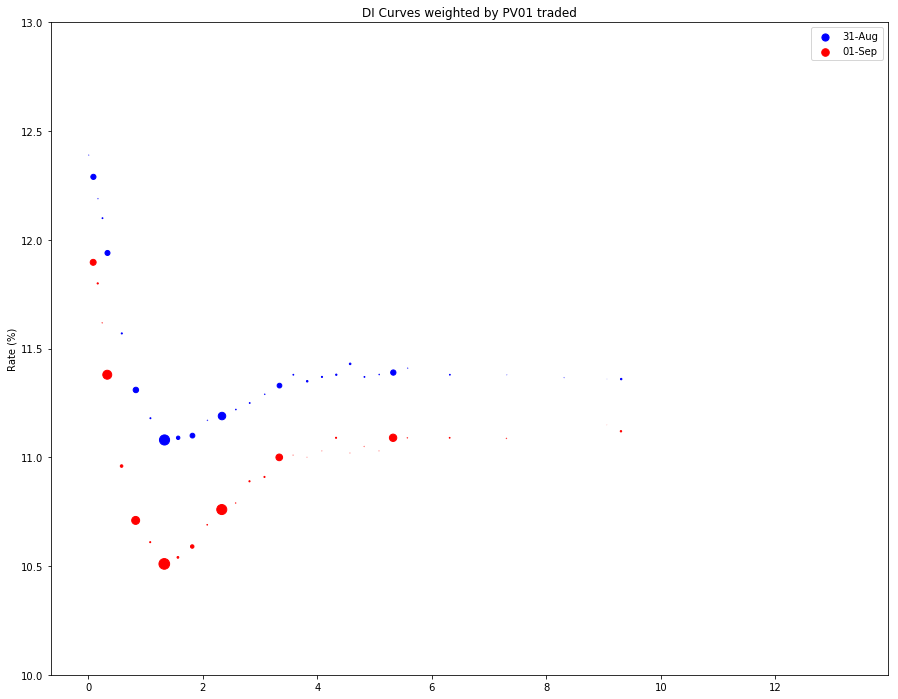

In [251]:
fig = plt.figure(figsize=(15, 12));#, dpi=1200);
plt.ylim(ymin = 10, ymax = 13);
plt.ylabel('Rate (%)');
plt.title('DI Curves weighted by PV01 traded');
scdate = '2011-08-31'
scatx = BVMFTS2.xs(scdate)['ttm'].values
scaty = BVMFTS2.xs(scdate)['rT'].values
scatsc = BVMFTS2.xs(scdate)['WCT'].values
scatsz = scatsc*2/10000
plt.scatter(scatx, scaty, s=scatsz, c='b');
scdate = '2011-09-01'
scatx = BVMFTS2.xs(scdate)['ttm'].values
scaty = BVMFTS2.xs(scdate)['rT'].values
scatsc = BVMFTS2.xs(scdate)['WCT'].values
scatsz = scatsc*2/10000
plt.scatter(scatx, scaty, s=scatsz, c='r');
plt.legend(['31-Aug','01-Sep'], loc = 'best');

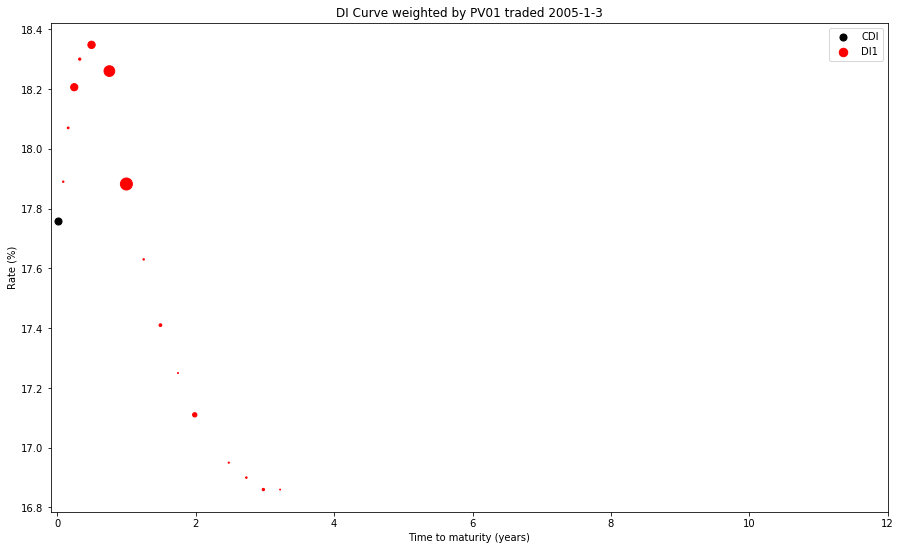

In [252]:
today='2005-1-3'

cdi=getv(today,'CDI')

fig = plt.figure(figsize=(15, 9))
plt.xlim(xmin = -0.1, xmax = 12)
plt.xlabel('Time to maturity (years)')
#plt.ylim(ymin = 10, ymax = 16)
plt.ylabel('Rate (%)')
scdate = today
plt.title('DI Curve weighted by PV01 traded '+scdate);
#cdi=np.array([BCBTS4.xs(scdate)['CDI']])
cdid=np.array([1/252])
plt.scatter(1/252,cdi,s=50,c='k')
scatb = BVMFTS2.xs(scdate)[['ttm','rT','WCT']].dropna()
scatx = scatb['ttm'].values
scaty = scatb['rT'].values
scatsc = scatb['WCT'].values
scatsz = scatsc*5*10/10000
plt.scatter(scatx, scaty, s=scatsz, c='r')
plt.legend(['CDI','DI1'], loc = 'best')

In [164]:
#BVMFTS2.xs(mattbl[u'V11 '], level=1)['rT']['2011-08-01':]

In [154]:
ctoc = 100*(BVMFTS2['rT']-BVMFTS2['rY']).dropna()

In [156]:
utdates = tdates.unique()

In [159]:
ctocv = [ctoc.xs(utdates[j])[0] for j in range(len(utdates))]

In [149]:
ctocs = pd.Series(ctocv, index = utdates)

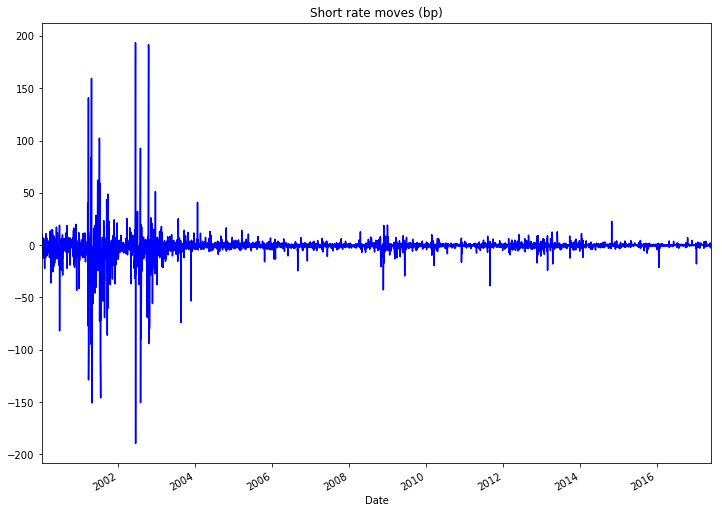

In [161]:
ctocs.plot(figsize=(12,9),color='blue',title='Short rate moves (bp)');

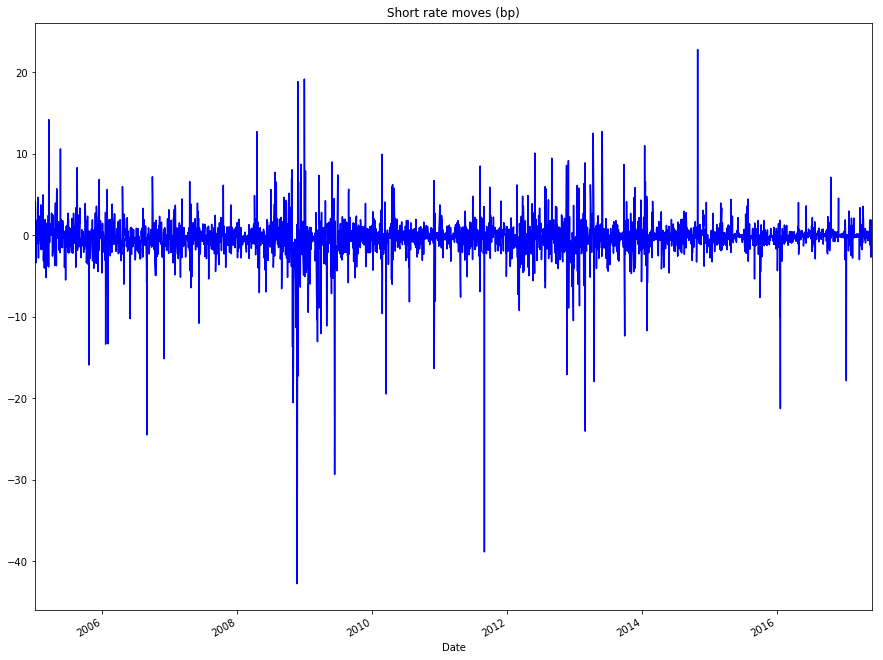

In [253]:
ctocs.loc['2005':].plot(figsize=(15,12),color='blue',title='Short rate moves (bp)');

In [163]:
ctocs[np.abs(ctocs)>15].loc['2005':]

Date
2005-10-20   -15.907565
2006-08-31   -24.481227
2006-11-30   -15.127058
2008-10-30   -20.520591
2008-10-31   -18.343785
2008-11-21   -42.744202
2008-11-25    18.869481
2008-11-26   -17.251641
2008-12-30    19.185011
2009-06-12   -29.337509
2010-03-18   -19.462627
2010-12-03   -16.341620
2011-09-01   -38.837292
2012-11-21   -17.079897
2013-02-28   -24.026892
2013-04-18   -17.929790
2014-10-30    22.806908
2016-01-21   -21.260692
2017-01-12   -17.832025
dtype: float64

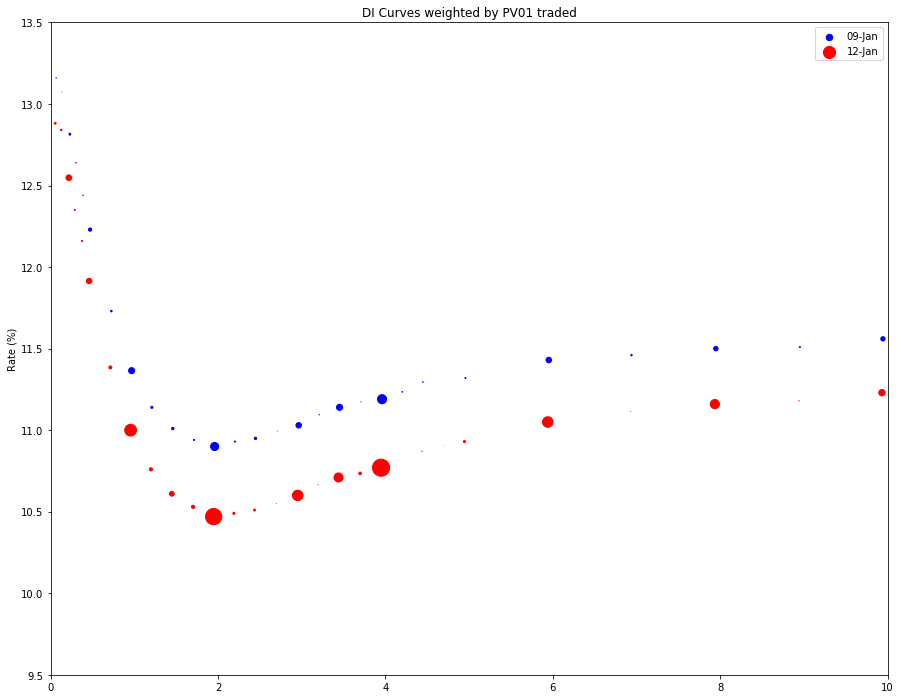

In [263]:
fig = plt.figure(figsize=(15, 12));
plt.xlim(xmin = 0, xmax = 10);
plt.ylim(ymin = 9.5, ymax = 13.5);
plt.ylabel('Rate (%)');
plt.title('DI Curves weighted by PV01 traded');
scdate = '2017-01-09'
scatx = BVMFTS2.xs(scdate)['ttm'].values
scaty = BVMFTS2.xs(scdate)['rT'].values
scatsc = BVMFTS2.xs(scdate)['WCT'].values
scatsz = scatsc*5/10000
plt.scatter(scatx, scaty, s=scatsz, c='b');
scdate = '2017-01-12'
scatx = BVMFTS2.xs(scdate)['ttm'].values
scaty = BVMFTS2.xs(scdate)['rT'].values
scatsc = BVMFTS2.xs(scdate)['WCT'].values
scatsz = scatsc*5/10000
plt.scatter(scatx, scaty, s=scatsz, c='r');
plt.legend(['09-Jan','12-Jan'], loc = 'best');

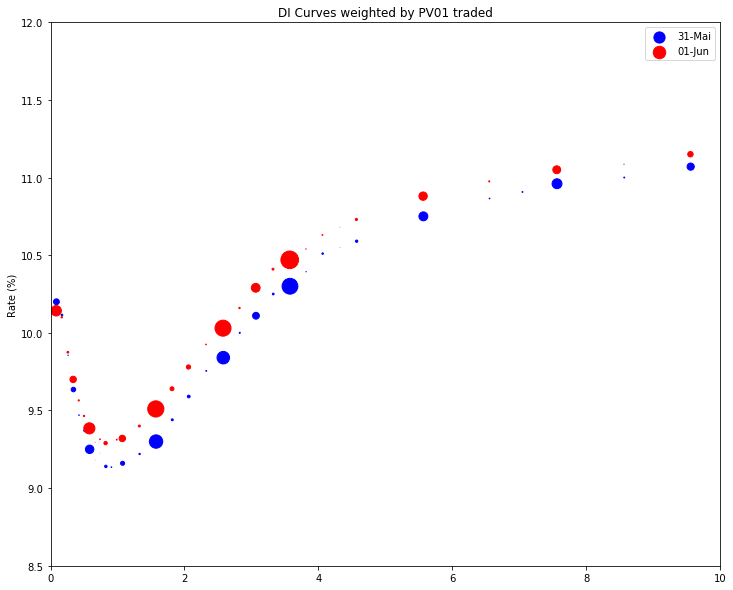

In [267]:
fig = plt.figure(figsize=(12, 10));
plt.xlim(xmin = 0, xmax = 10);
plt.ylim(ymin = 8.5, ymax = 12);
plt.ylabel('Rate (%)');
plt.title('DI Curves weighted by PV01 traded');
scdate = '2017-05-31'
scatx = BVMFTS2.xs(scdate)['ttm'].values
scaty = BVMFTS2.xs(scdate)['rT'].values
scatsc = BVMFTS2.xs(scdate)['WCT'].values
scatsz = scatsc*5/10000
plt.scatter(scatx, scaty, s=scatsz, c='b');
scdate = '2017-06-01'
scatx = BVMFTS2.xs(scdate)['ttm'].values
scaty = BVMFTS2.xs(scdate)['rT'].values
scatsc = BVMFTS2.xs(scdate)['WCT'].values
scatsz = scatsc*5/10000
plt.scatter(scatx, scaty, s=scatsz, c='r');
plt.legend(['31-Mai','01-Jun'], loc = 'best');

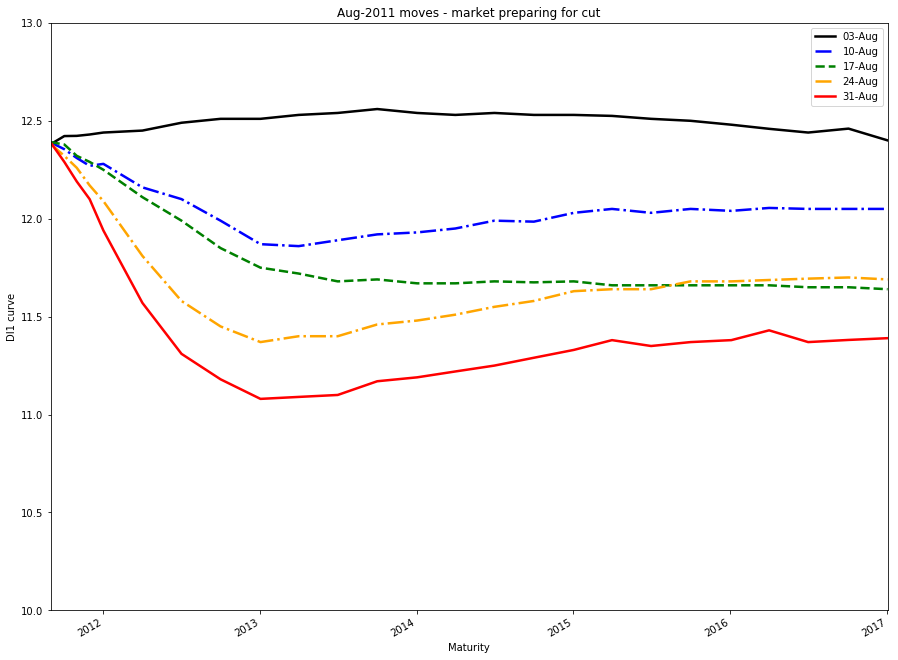

In [255]:
fig = plt.figure(figsize=(15,12))
plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('DI1 curve')
plt.title('Aug-2011 moves - market preparing for cut')
BVMFTS2.xs('2011-08-03')['rT']['2011-08-01':'2017-01-03'].plot(color='k', linewidth=2.5, linestyle='-')
BVMFTS2.xs('2011-08-10')['rT']['2011-08-01':'2017-01-03'].plot(color='b', linewidth=2.5, linestyle='-.')
BVMFTS2.xs('2011-08-17')['rT']['2011-08-01':'2017-01-03'].plot(color='g', linewidth=2.5, linestyle='--')
BVMFTS2.xs('2011-08-24')['rT']['2011-08-01':'2017-01-03'].plot(color='orange', linewidth=2.5, linestyle='-.')
BVMFTS2.xs('2011-08-31')['rT']['2011-08-01':'2017-01-03'].plot(color='r', linewidth=2.5, linestyle='-')
plt.legend(['03-Aug','10-Aug','17-Aug','24-Aug','31-Aug'], loc = 'best');

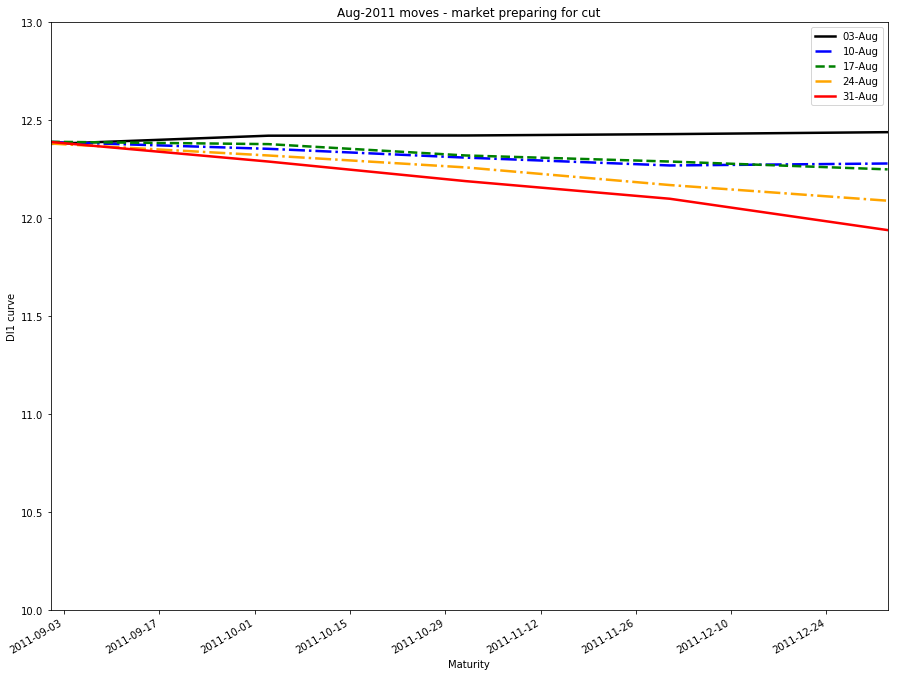

In [256]:
fig = plt.figure(figsize=(15,12))
plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('DI1 curve')
plt.title('Aug-2011 moves - market preparing for cut')
BVMFTS2.xs('2011-08-03')['rT']['2011-08-01':'2012-01-05'].plot(color='k', linewidth=2.5, linestyle='-')
BVMFTS2.xs('2011-08-10')['rT']['2011-08-01':'2012-01-05'].plot(color='b', linewidth=2.5, linestyle='-.')
BVMFTS2.xs('2011-08-17')['rT']['2011-08-01':'2012-01-05'].plot(color='g', linewidth=2.5, linestyle='--')
BVMFTS2.xs('2011-08-24')['rT']['2011-08-01':'2012-01-05'].plot(color='orange', linewidth=2.5, linestyle='-.')
BVMFTS2.xs('2011-08-31')['rT']['2011-08-01':'2012-01-05'].plot(color='r', linewidth=2.5, linestyle='-')
plt.legend(['03-Aug','10-Aug','17-Aug','24-Aug','31-Aug'], loc = 'best');

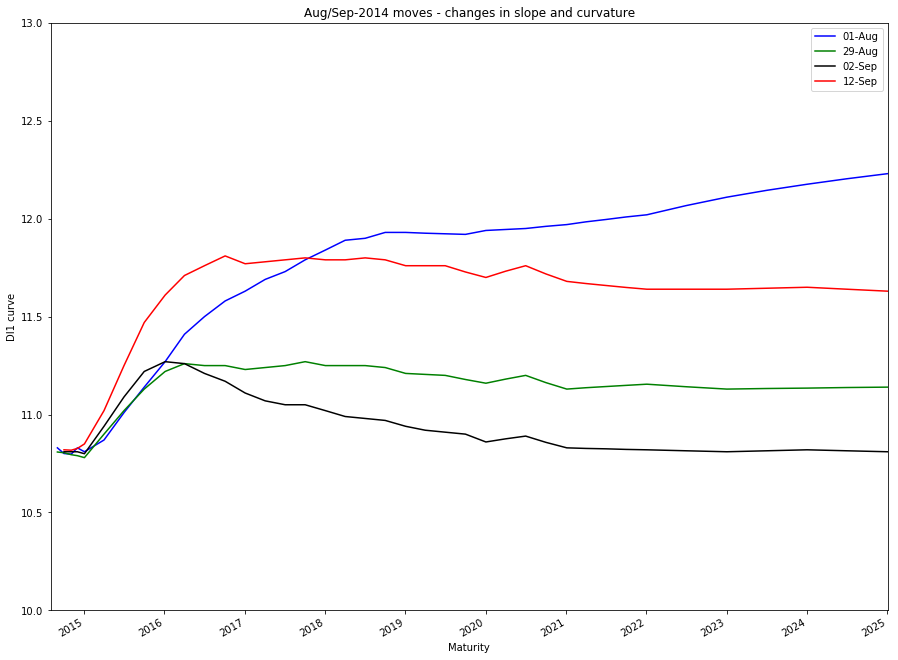

In [257]:
fig = plt.figure(figsize=(15,12));
plt.ylim(ymin = 10, ymax = 13);
plt.ylabel('DI1 curve');
plt.title('Aug/Sep-2014 moves - changes in slope and curvature')
BVMFTS2.xs('2014-08-01')['rT'][:-2].plot(color='b');
BVMFTS2.xs('2014-08-29')['rT'][:-2].plot(color='g');
BVMFTS2.xs('2014-09-02')['rT'][:-2].plot(color='k');
BVMFTS2.xs('2014-09-12')['rT'][:-2].plot(color='r');
plt.legend(['01-Aug','29-Aug','02-Sep','12-Sep'], loc = 'best');

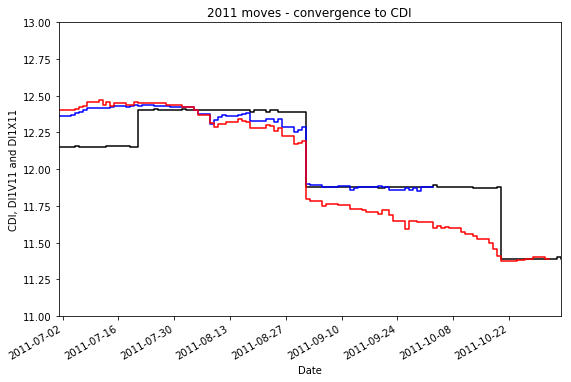

In [230]:
fig = plt.figure(figsize=(9, 6));
plt.ylim(ymin = 11, ymax = 13);
plt.ylabel('CDI, DI1V11 and DI1X11');
plt.title('2011 moves - convergence to CDI')
BCBTS['CDI']['2011-07-01':'2011-11-4'].plot(drawstyle='steps-post', color='k');
BVMFTS2.xs((mattbl[u'V11']),level=1)['rT']['2011-07-01':].plot(drawstyle='steps-post', color='b');
BVMFTS2.xs((mattbl[u'X11']),level=1)['rT']['2011-07-01':].plot(drawstyle='steps-post', color='r');

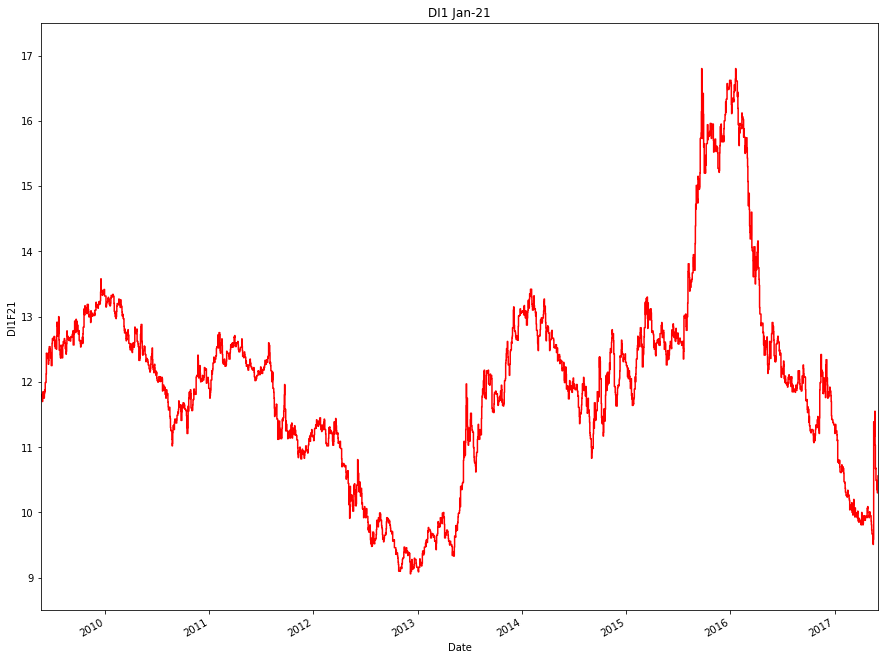

In [258]:
fig = plt.figure(figsize=(15, 12));
plt.ylim(ymin = 8.5, ymax = 17.5);
plt.ylabel('DI1F21');
plt.title('DI1 Jan-21')
BVMFTS2.xs((mattbl[u'F21']),level=1)['rT'].plot(drawstyle='steps-post', color='r');

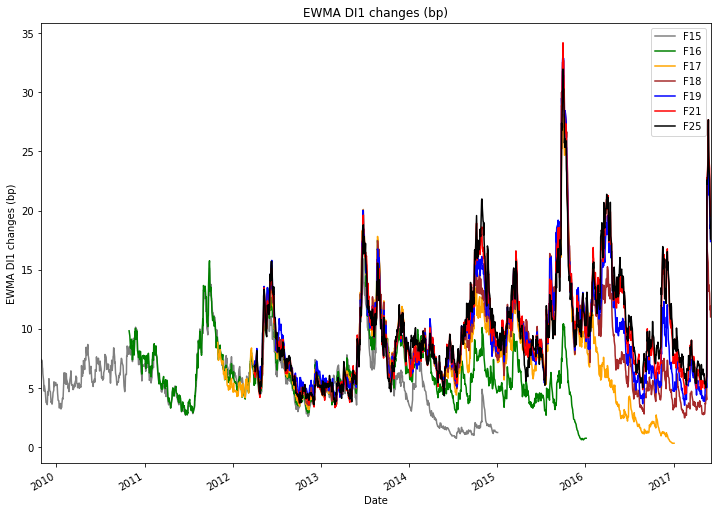

In [232]:
fig = plt.figure(figsize=(12, 9));
#plt.ylim(ymin = -60, ymax = 60)
plt.ylabel('EWMA DI1 changes (bp)');
plt.title('EWMA DI1 changes (bp)');
ewmaspan = 20
ewmapts = 5*252 + ewmaspan
#ewmapts = 100
rT = BVMFTS2.xs((mattbl[u'F15']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F15']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='gray');
rT = BVMFTS2.xs((mattbl[u'F16']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F16']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='g');
rT = BVMFTS2.xs((mattbl[u'F17']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F17']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='orange');
rT = BVMFTS2.xs((mattbl[u'F18']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F18']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='brown');
rT = BVMFTS2.xs((mattbl[u'F19']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F19']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='b');
rT = BVMFTS2.xs((mattbl[u'F21']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F21']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='r');
rT = BVMFTS2.xs((mattbl[u'F25']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F25']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='k');
plt.legend(['F15','F16','F17','F18','F19','F21','F25'], loc = 'best');

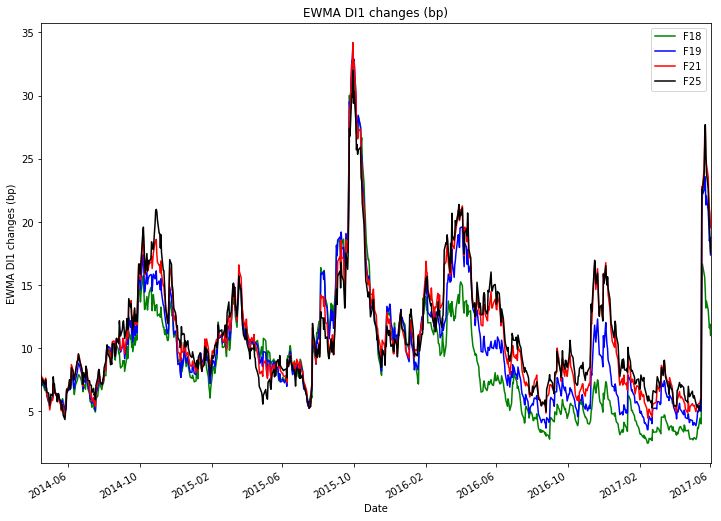

In [233]:
fig = plt.figure(figsize=(12, 9));
#plt.ylim(ymin = -60, ymax = 60)
plt.ylabel('EWMA DI1 changes (bp)');
plt.title('EWMA DI1 changes (bp)');
ewmaspan = 20
ewmapts = 3*252 + ewmaspan
#ewmapts = 100
rT = BVMFTS2.xs((mattbl[u'F18']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F18']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='g');
rT = BVMFTS2.xs((mattbl[u'F19']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F19']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='b');
rT = BVMFTS2.xs((mattbl[u'F21']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F21']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='r');
rT = BVMFTS2.xs((mattbl[u'F25']),level=1)['rT']
rY = BVMFTS2.xs((mattbl[u'F25']),level=1)['rY']
chgr = (100*(rT-rY))
ewmar = np.abs(chgr).ewm(span=ewmaspan).mean()
ewmar[-ewmapts:].plot(color='k');
plt.legend(['F18','F19','F21','F25'], loc = 'best');

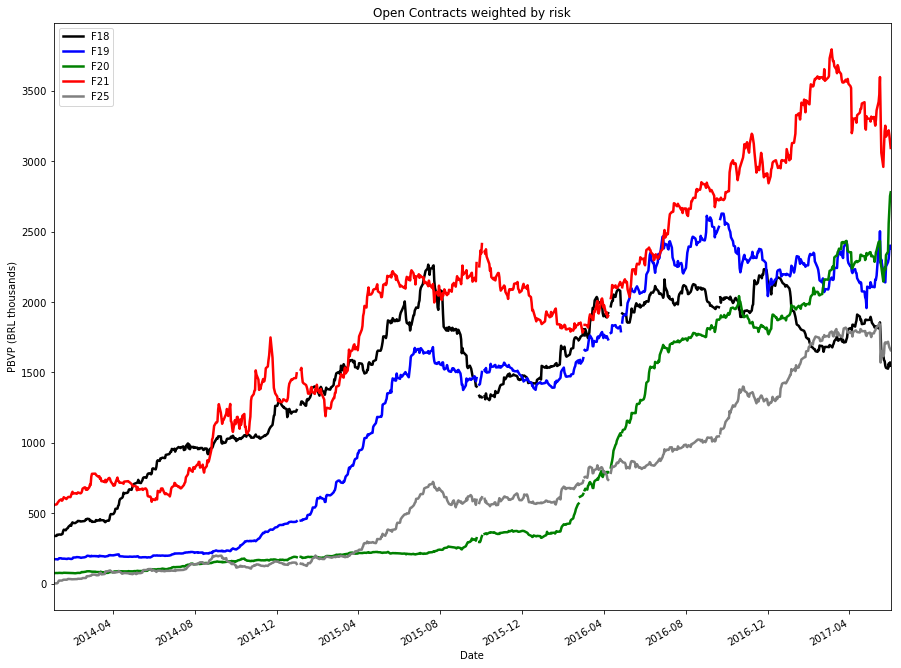

In [259]:
fig = plt.figure(figsize=(15, 12));
#plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('PBVP (BRL thousands)');
plt.title('Open Contracts weighted by risk');
(BVMFTS2.xs(mattbl[u'F18'], level=1)['WOCF']['2014':]/1000).plot(color='k', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F19'], level=1)['WOCF']['2014':]/1000).plot(color='b', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F20'], level=1)['WOCF']['2014':]/1000).plot(color='g', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F21'], level=1)['WOCF']['2014':]/1000).plot(color='r', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F25'], level=1)['WOCF']['2014':]/1000).plot(color='gray', linewidth=2.5, linestyle='-');
plt.legend(['F18','F19','F20','F21','F25'], loc = 'best');

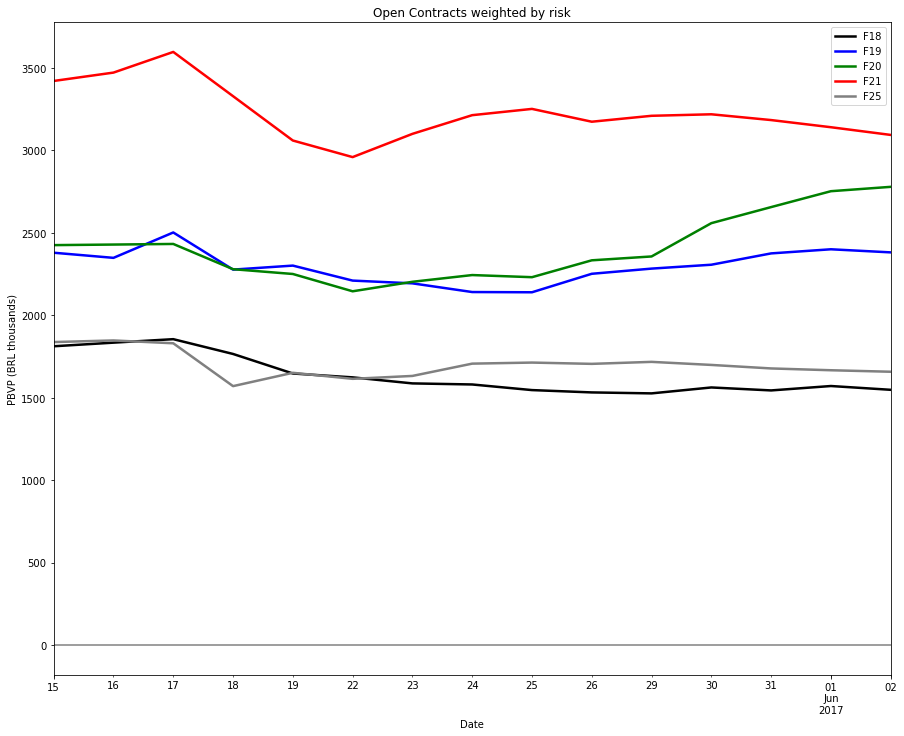

In [261]:
fig = plt.figure(figsize=(15,12));
#plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('PBVP (BRL thousands)');
plt.title('Open Contracts weighted by risk');
(BVMFTS2.xs(mattbl[u'F18'], level=1)['WOCF']['2017-05-15':]/1000).plot(color='k', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F19'], level=1)['WOCF']['2017-05-15':]/1000).plot(color='b', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F20'], level=1)['WOCF']['2017-05-15':]/1000).plot(color='g', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F21'], level=1)['WOCF']['2017-05-15':]/1000).plot(color='r', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F25'], level=1)['WOCF']['2017-05-15':]/1000).plot(color='gray', linewidth=2.5, linestyle='-');
plt.axhline(0,color='gray')
plt.legend(['F18','F19','F20','F21','F25'], loc = 'best');

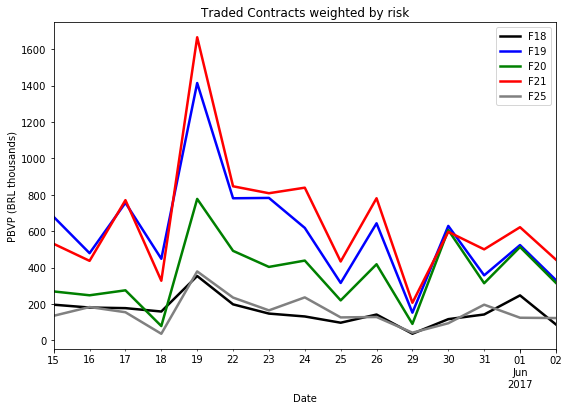

In [236]:
fig = plt.figure(figsize=(9, 6));
#plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('PBVP (BRL thousands)');
plt.title('Traded Contracts weighted by risk');
(BVMFTS2.xs(mattbl[u'F18'], level=1)['WCT']['2017-05-15':]/1000).plot(color='k', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F19'], level=1)['WCT']['2017-05-15':]/1000).plot(color='b', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F20'], level=1)['WCT']['2017-05-15':]/1000).plot(color='g', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F21'], level=1)['WCT']['2017-05-15':]/1000).plot(color='r', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F25'], level=1)['WCT']['2017-05-15':]/1000).plot(color='gray', linewidth=2.5, linestyle='-');
plt.legend(['F18','F19','F20','F21','F25'], loc = 'best');

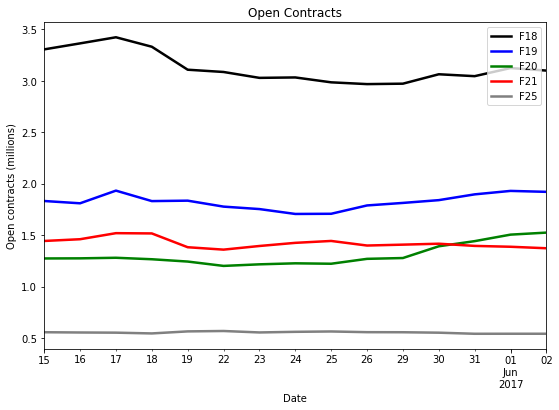

In [237]:
fig = plt.figure(figsize=(9, 6));
#plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('Open contracts (millions)');
plt.title('Open Contracts');
(BVMFTS2.xs(mattbl[u'F18'], level=1)['OCF']['2017-05-15':]/1000000).plot(color='k', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F19'], level=1)['OCF']['2017-05-15':]/1000000).plot(color='b', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F20'], level=1)['OCF']['2017-05-15':]/1000000).plot(color='g', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F21'], level=1)['OCF']['2017-05-15':]/1000000).plot(color='r', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F25'], level=1)['OCF']['2017-05-15':]/1000000).plot(color='gray', linewidth=2.5, linestyle='-');
plt.legend(['F18','F19','F20','F21','F25'], loc = 'best');

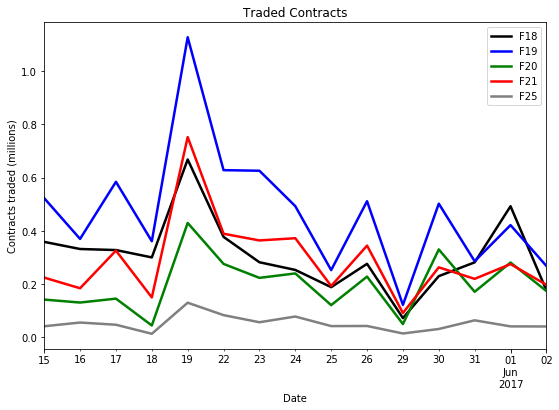

In [238]:
fig = plt.figure(figsize=(9, 6));
#plt.ylim(ymin = 10, ymax = 13)
plt.ylabel('Contracts traded (millions)');
plt.title('Traded Contracts');
(BVMFTS2.xs(mattbl[u'F18'], level=1)['CT']['2017-05-15':]/1000000).plot(color='k', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F19'], level=1)['CT']['2017-05-15':]/1000000).plot(color='b', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F20'], level=1)['CT']['2017-05-15':]/1000000).plot(color='g', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F21'], level=1)['CT']['2017-05-15':]/1000000).plot(color='r', linewidth=2.5, linestyle='-');
(BVMFTS2.xs(mattbl[u'F25'], level=1)['CT']['2017-05-15':]/1000000).plot(color='gray', linewidth=2.5, linestyle='-');
plt.legend(['F18','F19','F20','F21','F25'], loc = 'best');